# Analyse d'une image de microscopie à l'aide du module scikit image
Ce notebook à pour objectif d'ilustrer une utilisation simplifé du module scikit image pour l'analyse d'une image issue d'un microscope photonique à épifluorescence. On cherche à compter le nombre de noyaux, ainsi que leurs taille et leurs intensité de fluorescence.

## Chargement des modules

In [16]:
# Module standard.
import numpy as np
import matplotlib.pyplot as plt
# Module pour la manipulation d'image (scikit-image).

# sous-module contenant les fonctions de lecture et d'écriture d'une
# image.
import skimage.io
# Sous-module contenant les fonctions ...
import skimage.exposure
# Sous-module contenant les fonctions permettant de réaliser
# des mesures sur les images.
import skimage.measure
# Sous-module contenant les fonctions permmettant de réaliser
# un flitrage des image.
import skimage.filters

# module d'intéraction avec le système
import sys
import os

# Fonction pour le téléchargement de l'image à analiser
from urllib.request import urlretrieve

%matplotlib inline

## Téléchargement et décompréssion de l'image à analyser

In [5]:
# Téléchargement de l'image si elle n'est pas présente dans le répertoire
# courrant.
if not os.path.isfile('FluorescentCells.zip'):
    print('Downloading the TIFF file for fluorescent cells image...')
    try:
        urlretrieve('https://imagej.nih.gov/ij/images/FluorescentCells.zip',
            'FluorescentCells.zip')
        print("ok")
    except:
        print("Unable to download the file!")
    print('Done!')

# Décompression du fichier FluorescentCells.zip si l'image n'est pas
# décompréssée.
if not os.path.isfile("FluorescentCells.tif"):
    !unzip FluorescentCells.zip

## Chargement et visualisation de l'image à analyser

Chargement de l'image dans un array numpy, provennant d'[NIH](https://imagej.nih.gov/ij/images/FluorescentCells.zip).

In [17]:
img = skimage.io.imread("../img/FluorescentCells.tif")

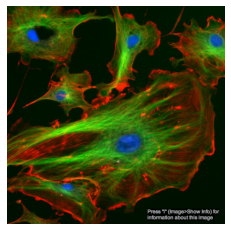

In [19]:
plt.imshow(img)
plt.axis("off");

L'image ci-dessus, que l'on va analyser (dont une description est disponible [ici](https://imagej.nih.gov/ij/images/FluorescentCells.txt)), correspond à une image de cellules endothéliales d'artère pulmonaire bovine. En bleu, il s'agit d'un marquage des noyaux à l'aide du DAPI. En vert, il s'agit d'un marquage de la tubuline. Puis en rouge, il s'agit d'un marquage des microtubules.

In [24]:
print(f"Dimensions du tableau numpy de l'image : {img.shape}")
print(f"Représentation du pixel (0, 0): {img[0, 0, :]}")

Dimensions du tableau numpy de l'image : (512, 512, 3)
Représentation du pixel (0, 0): [16 50  0]


Nous observons que notre image est tridimensionnelles dont la première dimension contient 512 colonnes, la seconde contient 512 ligne et la dernière correspondant aux différents canaux (RGB Dans notre exemple, le pixel (0, 0) à la valeur 16 pour le canal rouge, 50 pour le canal vert et 0 pour le canal bleu.

## Sélection du canal d'intérêt
Le canal d'intérêt est le bleu, puisque qu'il représente les noyaux marqué au DAPI. Il faudra alors utiliser l'indice 2 dans la troisième dimension du tableau numpy pour ce sélectionner ce canal.

In [22]:
canal_blue = img[:, :, 2]

### Affichage du canal d'intérêt

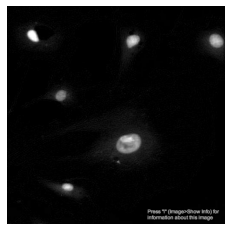

In [23]:
plt.imshow(canal_blue, cmap="gray")
plt.axis("off");

La sélection effectuée permet d'identifier clairement les noyaux. Nous remarquons également en bas à droite une zone de texte qui a été sélectionné. Région qui devra sûrement être filtré par la suite.

## Estimation du seuil de sélection des noyaux

Dans le but de sélectionner les noyaux, il est nécessaire d'utiliser un seuil d'intensité des pixels à conserver pour éliminer le bruit présent sur l'image précédente. Pour ce faire, nous allons réaliser un histogramme en utilsant `skimage.exposure.histogram()`, fonction qui renvoie les valeurs nécessaires à la construction du graphique qui permettra d'identifier le seuil de sélection.

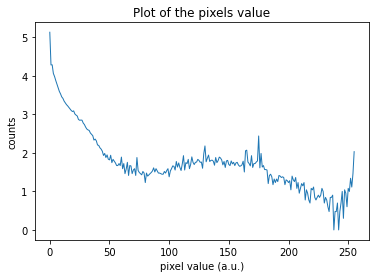

In [30]:
hist, bins = skimage.exposure.histogram(canal_blue)
plt.plot(bins, np.log10(hist), linewidth=1)
plt.xlabel('pixel value (a.u.)')
plt.ylabel('counts')
plt.title("Plot of the pixels value");

On remarque un minimum local en 80 pour la valeur des pixels. Nous allons donc prendre une valeur de seuil de 80 pour la sélection des noyaux. Nous stockerons ensuite dans l'objet `img_noyau` les pixels dont la valeur est supérieur au seuil définie.

In [32]:
seuil = 80
img_noyau = canal_blue > seuil

### Affichage de l'image après estimation du seuil

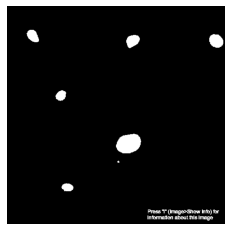

In [33]:
plt.imshow(img_noyau, cmap="gray")
plt.axis("off");

On remarque qu'en utilisant un seuil de 80, on a une sélection spécifique des noyaux. Hormis la zone de texte en bas à droite de l'image et d'une petite zone non spécifique d'un noyau.

Afin de pouvoir pousuivre l'analyse de cette image, nous devons retirer la zone de texte qui pourrait biaisé le résultat.  

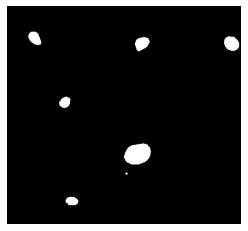

In [40]:
plt.imshow(img_noyau[:476, :], cmap = "gray")
plt.axis("off");

Par la sélection des lignes 0 à 475, on remarque que cela a pu retirer la zone de texte sans perte d'informations pour la suite de notre analyse.

In [45]:
img_noyau = img_noyau[:476, :]

## Comptage des noyaux présents dans notre image 

Nous allons maintenant effectuer le comptage de nos noyaux à l'aide de la fonction `skimage.measure.label()`. 

La fonction a identifié 7 noyaux.


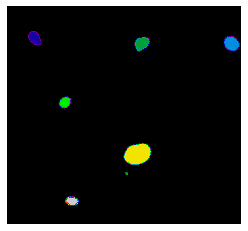

In [59]:
img_noyau_lab, num_noyau = skimage.measure.label(img_noyau, return_num = True)
plt.imshow(img_noyau_lab, cmap = "nipy_spectral")
plt.axis("off")
print(f"La fonction a identifié {num_noyau} noyaux.")

On remarque sous le noyau coloré en jaune sur l'image la présence d'un petit artéfact qui a été comptabilisé comme un noyau. Alors que cela est peu probable qu'il s'agisse d'un noyau.  

## Sélection individuelle des noyaux

In [62]:
noyau_indi = []
for i in range(1, num_noyau + 1):
    noyau_indi.append(img_noyau_lab == i)

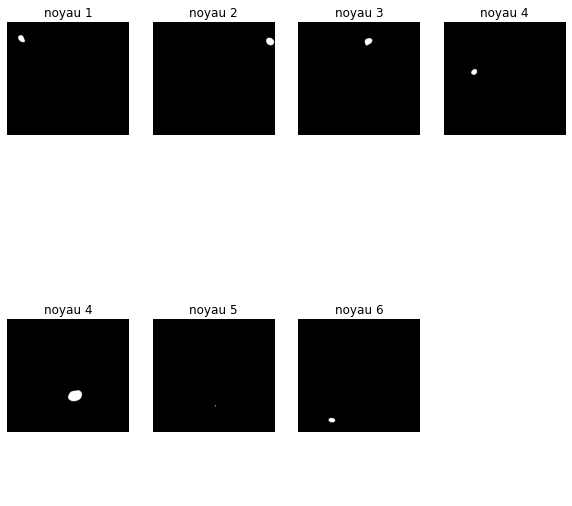

In [98]:
fig, sub = plt.subplots(nrows=2, ncols=4, figsize = (10, 10))
for i in range(4):
    sub[0, i].imshow(noyau_indi[i], cmap="gray")
    sub[0,i].set_title(f"noyau {i + 1}")
    sub[0, i].axis("off")
for i in range(3):
    sub[1, i].imshow(noyau_indi[i+4], cmap="gray")    
    sub[1,i].set_title(f"noyau {i + 4}")

    sub[1, i].axis("off")
sub[1, 3].axis("off");

## Calcul de l'aire des noyaux

Afin de calculer l'aire d'un noyau, nous devons faire la somme des picels allumés par images de noyaux individualisées.

In [130]:
pixel_noyau = []
for noyau in noyau_indi:
    pixel_noyau.append(np.sum(noyau))

for nb_pixel in pixel_noyau:
    print(f"Aire du noyau {pixel_noyau.index(nb_pixel)} = {nb_pixel} pixels")

Aire du noyau 0 = 593 pixels
Aire du noyau 1 = 824 pixels
Aire du noyau 2 = 705 pixels
Aire du noyau 3 = 454 pixels
Aire du noyau 4 = 2097 pixels
Aire du noyau 5 = 18 pixels
Aire du noyau 6 = 406 pixels


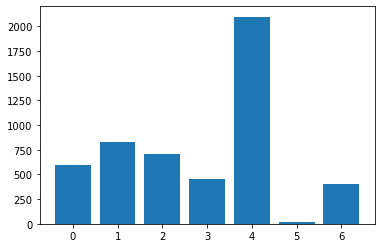

In [125]:
plt.bar(range(7), pixel_noyau);

On observe ici que le noyau 5 a une aire beaucoup plus faible que les autres noyau. Confirmant notre que le noyau 5 semble bien être un artéfact que nous ne prendrons pas en compte lors de la suite de nos analyses.

### Conversion de l'aire des noyaux en $\mu m^2$  

In [147]:
dist_pixel = 0.160
area_noyau = list(np.array(pixel_noyau) * (dist_pixel)**2)
for area in area_noyau:
    print(f"Aire noyau {area_noyau.index(area)} = {area:>6.3f} square microns")

Aire noyau 0 = 15.181 square microns
Aire noyau 1 = 21.094 square microns
Aire noyau 2 = 18.048 square microns
Aire noyau 3 = 11.622 square microns
Aire noyau 4 = 53.683 square microns
Aire noyau 5 =  0.461 square microns
Aire noyau 6 = 10.394 square microns


In [132]:
area_noyau

array([15.1808, 21.0944, 18.048 , 11.6224, 53.6832,  0.4608, 10.3936])

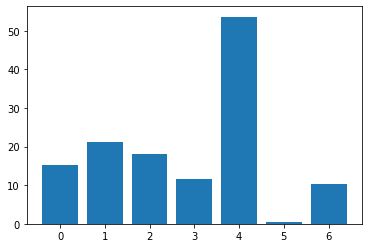

In [133]:
plt.bar(range(7), area_noyau);

In [ ]:
area_noyau.pop(5)
pixel_noyau.pop(5)

### Ajout d'un filtre gaussien

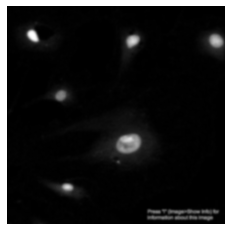

In [10]:
nuclei_filtered = skimage.filters.gaussian(canal_blue, sigma=2)
plt.imshow(nuclei_filtered, cmap="gray")
plt.axis("off");

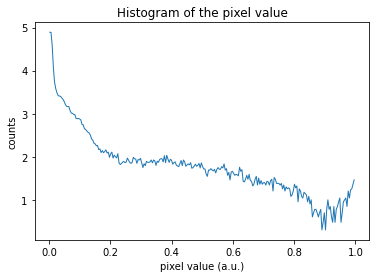

In [11]:
hist, bins = skimage.exposure.histogram(nuclei_filtered)
plt.plot(bins, np.log10(hist+1), linewidth=1)
plt.xlabel('pixel value (a.u.)')
plt.ylabel('counts')
plt.title("Histogram of the pixel value");

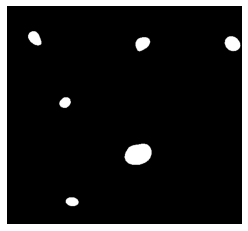

In [ ]:
seuil = 0.3
img_noyau = nuclei_filtered > seuil
plt.imshow(img_noyau[:475, :], cmap="gray")
plt.axis("off");

On remarque qu'avec l'application d'un filtre gaussien et l'utilisation d'un seuil de 0.3, on obtient une sélection plus spécifique des nouyaux.

## Comptage du nombre de noyaux

In [52]:
labels, num_noyau = skimage.measure.label(img_noyau[:475,:], return_num = True)
print(labels.shape)
print(num_noyau)

(475, 512)
7


On obtient un comptage de 6 noyaux pour cette image, une fois le texte enlever.